# Neural Network Extraction
### _Adversarial Robustness_ Workshop for ML Conference 2022 
#### (scheduled for December 1st, 2022 1:30 PM CEST)

This notebook will walk through:



- Model Stealing Demo (updated from [here](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/model-stealing-demo.ipynb))

## The Preparations

### Installing the Libraries

In [ ]:
!pip install --upgrade numpy scikit-learn tensorflow matplotlib seaborn
!pip install --upgrade machine-learning-datasets
!pip install adversarial-robustness-toolbox==1.12.2

### Loading the Libraries

In [4]:
%%time
import math
import art
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import tensorflow as tf

from art.estimators.classification import KerasClassifier
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.defences.postprocessor import ReverseSigmoid

CPU times: user 641 µs, sys: 30 µs, total: 671 µs
Wall time: 681 µs


We should also disable eager execution and verify that it worked with the following commands. The output should say that it's `False`:

In [5]:
tf.compat.v1.disable_eager_execution()
print('Eager execution enabled: ', tf.executing_eagerly()) 

Eager execution enabled:  False


### Understanding and Preparing the Data

In [6]:
# Prepare the dataset and the model architecture.
from art.utils import load_mnist

# Load the dataset, and split the test data into test and steal datasets.
(x_train, y_train), (x_test0, y_test0), _, _ = load_mnist()
len_steal = 5000
indices = np.random.permutation(len(x_test0))
x_steal = x_test0[indices[:len_steal]]
y_steal = y_test0[indices[:len_steal]]
x_test = x_test0[indices[len_steal:]]
y_test = y_test0[indices[len_steal:]]

### Create Base Model

In [7]:
im_shape = x_train[0].shape

def get_model(num_classes=10, c1=32, c2=64, d1=128):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(c1, kernel_size=(3, 3), activation='relu', input_shape=im_shape))
    model.add(tf.keras.layers.Conv2D(c2, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(d1, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer="sgd",
                          metrics=['accuracy'])
    return model

### Train Base Model

In [8]:
# Train the original model.
num_epochs = 5
model = get_model(num_classes=10, c1=32, c2=64, d1=128)
print("Original model training:")
model.fit(x_train, y_train, batch_size=100, epochs=num_epochs)
print("Original model evaluation:")
print(model.evaluate(x_test, y_test))
classifier_original = KerasClassifier(model, clip_values=(0, 1), use_logits=False)

Original model training:
Train on 60000 samples
Epoch 1/5


2022-12-01 02:42:08.938906: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


60000/60000 [==============================] - 76s 1ms/sample - loss: 0.6698 - accuracy: 0.8178
Epoch 2/5
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.2479 - accuracy: 0.9253
Epoch 3/5
60000/60000 [==============================] - 76s 1ms/sample - loss: 0.1876 - accuracy: 0.9436
Epoch 4/5
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.1530 - accuracy: 0.9544
Epoch 5/5
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.1291 - accuracy: 0.9614
Original model evaluation:


/Users/serg/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[0.1286256356716156, 0.9612]


## Stealing
### Stealing from the unprotected classifier

In [9]:
# Stealing from the unprotected classifier.

attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

results = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 2ms/sample - loss: 2.3119 - accuracy: 0.0600
Epoch 2/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.2969 - accuracy: 0.0840
Epoch 3/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.2825 - accuracy: 0.1520
Epoch 4/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.2690 - accuracy: 0.2760
Epoch 5/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.2547 - accuracy: 0.3320
Probabilistic CopycatCNN : 0.34
Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.3016 - accuracy: 0.1040
Epoch 2/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.2879 - accuracy: 0.1240
Epoch 3/5
250/250 [==============================] - 0s 2ms/sample - loss: 2.2748 - accuracy: 0.2000
Epoch 4/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.2616 - accuracy: 0.2720
Epoch 5/5
250/250

### Evaluate Stolen Models

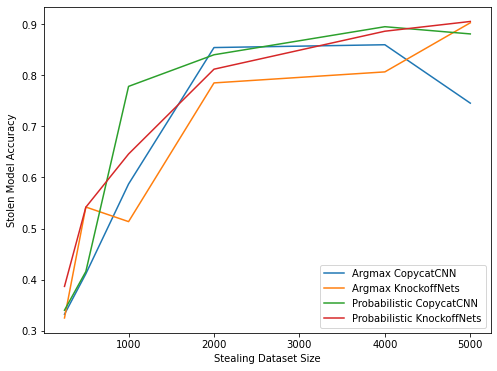

In [10]:
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

## Defense
### Defend with Reverse Sigmoid

In [14]:
# Prepare the defense layer.
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2)
classifier_protected = KerasClassifier(model, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

# Below is used by `FunctionallyEquivalentExtraction`.
model_flat = tf.keras.models.Sequential([tf.keras.layers.InputLayer([784]), tf.keras.layers.Reshape([28, 28, 1]), model])
model_flat.compile('sgd', 'categorical_crossentropy', ['accuracy'])
classifier_flat_protected = KerasClassifier(model_flat, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

### Attack Protected Classifier

In [15]:
%%time
# Stealing from the protected classifier.

attack_catalogue = {
                    "Probabilistic CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
#                     "FunctionallyEquivalentExtraction": FunctionallyEquivalentExtraction(classifier=classifier_flat_protected,
#                                               num_neurons=128),  # This one takes too long time for this dataset/model.
                    }

results_protected = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        if name=="FunctionallyEquivalentExtraction":
            classifier_stolen = attack.extract(np.reshape(x_steal, [len(x_steal), -1]), y_steal, thieved_classifier=classifier_stolen)
        else:
            classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results_protected.append((name, len_steal, acc))


Train on 250 samples
Epoch 1/5
250/250 [==============================] - 2s 6ms/sample - loss: 2.3051 - accuracy: 0.0520
Epoch 2/5
250/250 [==============================] - 1s 2ms/sample - loss: 2.3048 - accuracy: 0.0560
Epoch 3/5
250/250 [==============================] - 0s 2ms/sample - loss: 2.3045 - accuracy: 0.0560
Epoch 4/5
250/250 [==============================] - 0s 2ms/sample - loss: 2.3042 - accuracy: 0.0560
Epoch 5/5
250/250 [==============================] - 0s 2ms/sample - loss: 2.3039 - accuracy: 0.0600


/Users/serg/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Probabilistic CopycatCNN (vs. Protected) : 0.06605128
Train on 250 samples
Epoch 1/5
250/250 [==============================] - 1s 3ms/sample - loss: 2.3133 - accuracy: 0.0960
Epoch 2/5
250/250 [==============================] - 0s 2ms/sample - loss: 2.2954 - accuracy: 0.1520
Epoch 3/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.2768 - accuracy: 0.2080
Epoch 4/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.2588 - accuracy: 0.2720
Epoch 5/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.2407 - accuracy: 0.3800
Argmax CopycatCNN (vs. Protected) : 0.31507692
Probabilistic KnockoffNets (vs. Protected) : 0.08133333
Argmax KnockoffNets (vs. Protected) : 0.36


/Users/serg/opt/anaconda3/lib/python3.7/site-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)


Train on 500 samples
Epoch 1/5
500/500 [==============================] - 1s 1ms/sample - loss: 2.3041 - accuracy: 0.0760
Epoch 2/5
500/500 [==============================] - 1s 2ms/sample - loss: 2.3034 - accuracy: 0.0740
Epoch 3/5
500/500 [==============================] - 1s 1ms/sample - loss: 2.3028 - accuracy: 0.0720
Epoch 4/5
500/500 [==============================] - 1s 1ms/sample - loss: 2.3024 - accuracy: 0.0700
Epoch 5/5
500/500 [==============================] - 1s 1ms/sample - loss: 2.3020 - accuracy: 0.0720
Probabilistic CopycatCNN (vs. Protected) : 0.10136842
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 1s 2ms/sample - loss: 2.3011 - accuracy: 0.1640
Epoch 2/5
500/500 [==============================] - 1s 2ms/sample - loss: 2.2798 - accuracy: 0.2200
Epoch 3/5
500/500 [==============================] - 1s 2ms/sample - loss: 2.2579 - accuracy: 0.2860
Epoch 4/5
500/500 [==============================] - 1s 1ms/sample - loss: 2.2325 - accuracy: 0.

### Evaluate Attacked Protected Classifier

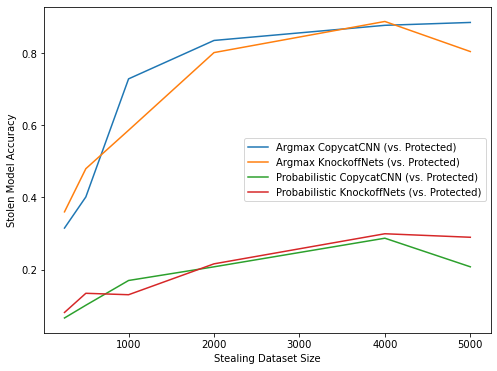

In [16]:
df_protected = pd.DataFrame(results_protected, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df_protected.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [17]:
df_combined = pd.concat([df, df_protected])
groupby = df_combined.groupby("Method Name")

/Users/serg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/Users/serg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


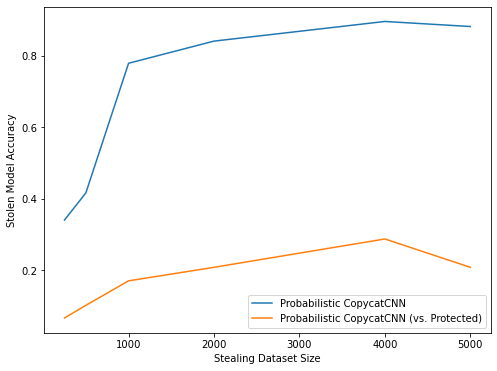

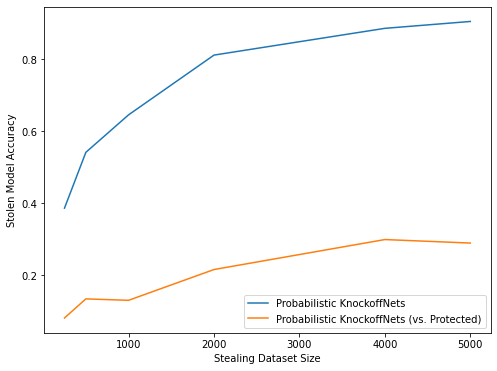

In [18]:
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (vs. Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (vs. Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()